# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import pdfo
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess
import eofs
import xrft
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import warnings

import pyarrow as pa
import pyarrow.parquet as pq

from IPython.display import display, clear_output

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from fair import *

## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.tab10().to_sn_palette()))
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

plt.rcParams['hatch.color']='k'
plt.rcParams['hatch.linewidth']=0.5

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=False,lon=False):
    if not lon is False:
        ax.set_xticks(lon, crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if not lat is False:
        ax.set_yticks(lat, crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Define functions

In [3]:
## function for hacking seaborn's catplot to make it pretty

def hack_catplot_range(x,y,hue,ci=66,dodge=False,hue_order=False,palette=False,**kwargs):
    
    x = x.astype(str)
    
    # calculate desired quantiles
    quantiles = [0.5-ci/200 , 0.5+ci/200]
    
    # calculate x data
    plot_x = dict(zip(x.unique(),np.arange(x.unique().size)))
    
    # if hue order
    if not hue_order:
        hue_order = hue.unique().tolist()
    
    hue_number = len(hue_order)
    
    # if dodge
    if dodge:
        plot_x_dodge = dict(zip(hue_order,np.linspace(-dodge/2,dodge/2,hue_number)))
    else:
        plot_x_dodge = dict(zip(hue.unique(),np.zeros(hue_number)))
    
    # groupby x,hue and plot
    for i,((x_level,hue_level),gr) in enumerate(y.groupby([x,hue])):
        
        if palette:
            kwargs['color'] = palette[hue_order.index(hue_level)]
        
        _y = np.nanquantile(gr.values,quantiles,interpolation='nearest')
        ## replace infs
        _y = np.where(np.isinf(_y),999999,_y)
        
        _x = plot_x[x_level] + plot_x_dodge[hue_level]
        
        plt.vlines(_x,*_y,lw=matplotlib.rcParams['lines.linewidth']*1.8,**kwargs)

In [4]:
palette = get_palette.IBM_color_blind().to_sn_palette()

# Retrieve data

Get Anthropogenic Warming Index.

In [5]:
## HadCRUT5
HC5 = xr.open_dataset('./ancil/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
HC5 = HC5.tas_mean.to_pandas()
HC5.index = HC5.index.year

## ERF components from AR6
erf_ar6 = pd.read_csv('./ancil/AR6_ERF_1750-2019.csv',index_col=0)

## ant / nat FaIR run
fair_erf = pd.DataFrame(index=erf_ar6.index,columns=pd.MultiIndex.from_product([['ant','aer','nat'],['forcing']]),data=pd.concat([erf_ar6.loc[:,'total_anthropogenic']-erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'total_natural']],axis=1).values)
fair_emms = return_empty_emissions(start_year=1750,end_year=2019,scen_names=['ant','aer','nat'])
fair_temps = run_FaIR(emissions_in=fair_emms,forcing_in=fair_erf)['T'].loc[1850:]

## regress HadCRUT5 onto FaIR temperature output & define anthropogenic warming index
X = np.column_stack([np.ones(fair_temps.index.size),fair_temps])
Y = HC5.loc[1850:2019].values[:,None]
mlr = OLSE.multiple(Y)
mlr.fit(X)
AWI = ( mlr.B[1]*fair_temps.aer + mlr.B[2]*fair_temps.ant ).default

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 269/269 [00:00<00:00, 2856.56 timestep/s]


## REGIONS

Get E-Obs observations.

In [6]:
def preproc_eobs_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-1].split('_')[-2]
    RG = ds.encoding['source'].split('/')[-2]
    ds['time'] = ds.time.dt.year
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

EObs_RG = xr.open_mfdataset('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Obsv_return/regions/*/E_Obs_0.25deg_TX*av_*.nc',preprocess=preproc_eobs_rg).sel(metric=['TX10av','TX1av','TX90av']).squeeze()

Get HadGEM3A simulations.

In [7]:
def preproc_hadgem_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-2]
    RG = ds.encoding['source'].split('/')[-3]
    ds = ds.assign_coords(record=np.arange(ds.record.size))
    ds['time'] = ds.time.dt.year
    ds['tas'] = ds.tas-273.15
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)
    
NAT_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/NAT/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
NAT_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_hadgem_rg,concat_dim='region').sel(time=2018) for x in NAT_paths],dim='metric').squeeze().load()

ACT_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/ACT/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
ACT_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_hadgem_rg,concat_dim='region').sel(time=2018) for x in ACT_paths],dim='metric').squeeze().load()

CLIM_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/clim/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
CLIM_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_hadgem_rg,concat_dim='region') for x in CLIM_paths],dim='metric').squeeze().load()

## replace the missing ACT member with the ensemble average
ACT_RG['tas'][-1,-2,-1] = ACT_RG.tas.sel(metric='TX90av',region='MD').mean('record').values

In [8]:
## add 15 members of ACT to CLIM (per E-Obs)
CLIM_RG = xr.concat([CLIM_RG,ACT_RG.isel(record=np.random.choice(525,15)).assign_coords(record=np.arange(15))],dim='time')

# Analysis - regions
For the regional analysis, we'll bootstrap everything to identify uncertainties about the best-estimate probability ratio.

## Observed return time

### bootstrap obervations

In [9]:
## set the number of bootstrap members
n_boot = 10000

def generate_boot(ds):
    
    ## bootstrap the samples
    x = ds.values
    np.random.seed(0)
    seed = np.random.choice(x.shape[0],x.shape[0]*n_boot)
    
    ## set the first seed equal to the original data for ease
    seed[::n_boot] = np.arange(x.shape[0])
    
    boot = x[seed].reshape(x.shape[0],seed.size//x.shape[0],*x.shape[1:])
    
    coords = dict(ds.coords)
    coords['seed'] = np.arange(n_boot)
    
    ds_out = xr.DataArray(boot, dims=[ds.dims[0],'seed',*ds.dims[1:]], coords=coords).rename(ds.name).to_dataset()
    
    ## need to record the years for detrending
    idx_boot = ds[ds.dims[0]].values[seed].reshape(x.shape[0],seed.size//x.shape[0])
    
    idx_coords = dict(ds[ds.dims[0]].coords)
    idx_coords['seed'] = np.arange(n_boot)
    
    ds_out['idx_'+ds.dims[0]] = xr.DataArray(idx_boot, dims=[ds.dims[0],'seed'], coords=idx_coords)
    
    return ds_out

EObs_RG_boot = generate_boot(EObs_RG.tg)

In [10]:
vector_sel = np.vectorize(lambda x: x[0])

CLIM_RG_boot = generate_boot(CLIM_RG.tas.stack(idx=['time','record']).transpose('idx',...))
CLIM_RG_boot['idx_idx'] = (['idx','seed'],vector_sel(CLIM_RG_boot.idx_idx.values))

ACT_RG_boot = generate_boot(ACT_RG.tas.transpose('record',...))
NAT_RG_boot = generate_boot(NAT_RG.tas.transpose('record',...))

### detrend

In [11]:
## detrend observations using AWI
slr = OLSE.simple(EObs_RG_boot.tg.values)
slr.fit(AWI.loc[EObs_RG_boot.idx_time.values.flatten()].values.reshape(EObs_RG_boot.idx_time.shape)[...,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
EObs_RG_boot['tg_trend'] = (['seed','metric','region'],slr.b1)
EObs_RG_boot['tg_dt'] = EObs_RG_boot.tg - (slr.pred() - slr.pred(AWI.loc[2018]))

''

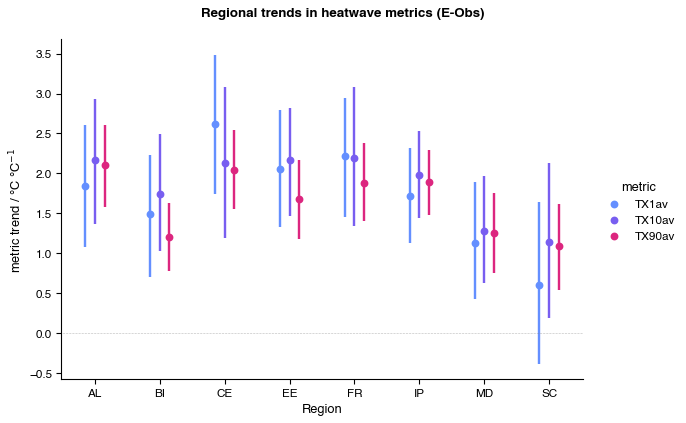

In [12]:
g=sn.catplot(data=EObs_RG_boot.tg_trend.to_dataframe().tg_trend.reset_index(),y='tg_trend',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','tg_trend','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='metric trend / \N{DEGREE SIGN}C \N{DEGREE SIGN}C$^{-1}$',xlabel='Region')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('Regional trends in heatwave metrics (E-Obs)',fontweight='bold',y=1.05)
''

### EVT

In [13]:
## fit GEV distributions to the detrended data
gev = LMoments.gev()
gev.fit(EObs_RG_boot.tg_dt.values)

RP = 1/(1-gev.cdf(EObs_RG.tg.sel(time=2018).values))

EObs_RG_boot['RP'] = (['seed','metric','region'], RP)

## repeat with GLO for TX90av
glo = LMoments.glo()
glo.fit(EObs_RG_boot.tg_dt.sel(metric='TX90av').values)

EObs_RG_boot['RP'][:,-1] = 1/(1-glo.cdf(EObs_RG.tg.sel(metric='TX90av',time=2018).values))

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


''

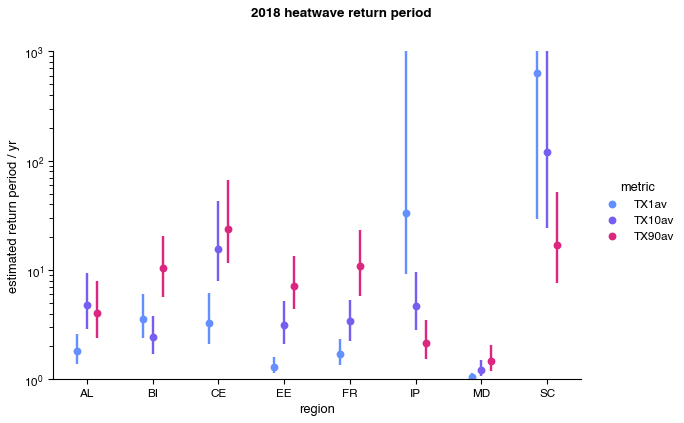

In [14]:
g=sn.catplot(data=EObs_RG_boot.RP.to_dataframe().RP.reset_index(),y='RP',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','RP','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='estimated return period / yr',xlabel='region',yscale='log',ylim=(1,1e3))
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('2018 heatwave return period',fontweight='bold',y=1.05)
''

## Climatological threshold

### detrend

In [15]:
## detrend climatology using AWI (averaging over ensemble members)
slr = OLSE.simple(CLIM_RG_boot.tas.values)
slr.fit(AWI.loc[CLIM_RG_boot.idx_idx.values.flatten()].values.reshape(CLIM_RG_boot.idx_idx.shape)[...,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
CLIM_RG_boot['tas_trend'] = (['seed','metric','region'],slr.b1)
CLIM_RG_boot['tas_dt'] = CLIM_RG_boot.tas - (slr.pred() - slr.pred(AWI.loc[2018]))

''

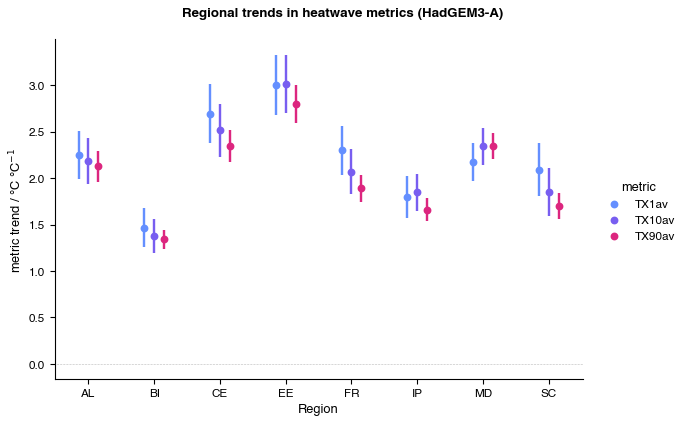

In [16]:
g=sn.catplot(data=CLIM_RG_boot.tas_trend.to_dataframe().tas_trend.reset_index(),y='tas_trend',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','tas_trend','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='metric trend / \N{DEGREE SIGN}C \N{DEGREE SIGN}C$^{-1}$',xlabel='Region')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('Regional trends in heatwave metrics (HadGEM3-A)',fontweight='bold',y=1.05)
''

### EVT

In [17]:
## fit GEV distributions to the detrended data
gev = LMoments.gev()
gev.fit(CLIM_RG_boot.tas_dt.transpose('idx',...).values)

threshold = gev.qf(1-1/EObs_RG_boot.RP.values)

CLIM_RG_boot['tas_threshold'] = (['seed','metric','region'], threshold)

## repeat with GLO for TX90av
glo = LMoments.glo()
glo.fit(CLIM_RG_boot.tas_dt.sel(metric='TX90av').transpose('idx',...).values)

CLIM_RG_boot['tas_threshold'][:,-1] = glo.qf(1-1/EObs_RG_boot.RP.sel(metric='TX90av').values)

''

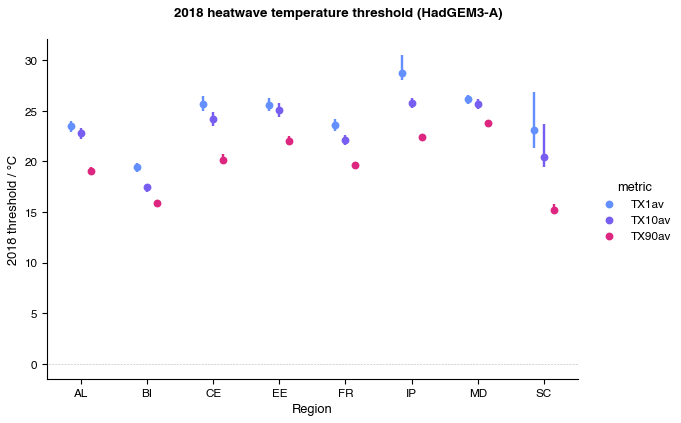

In [18]:
g=sn.catplot(data=CLIM_RG_boot.tas_threshold.to_dataframe().tas_threshold.reset_index(),y='tas_threshold',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','tas_threshold','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='2018 threshold / \N{DEGREE SIGN}C',xlabel='Region')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('2018 heatwave temperature threshold (HadGEM3-A)',fontweight='bold',y=1.05)
''

## Probability ratios

### EVT

In [19]:
## ACT
ACT_gev = LMoments.gev()
ACT_gev.fit(ACT_RG_boot.tas.transpose('record','seed',...).values)
ACT_RP = 1/(1-ACT_gev.cdf(CLIM_RG_boot.tas_threshold.values))
ACT_RG_boot['RP'] = (['seed','metric','region'],ACT_RP)

## NAT
NAT_gev = LMoments.gev()
NAT_gev.fit(NAT_RG_boot.tas.transpose('record','seed',...).values)
NAT_RP = 1/(1-NAT_gev.cdf(CLIM_RG_boot.tas_threshold.values))
NAT_RG_boot['RP'] = (['seed','metric','region'],NAT_RP)

## Repeat with GLO for TX90av
### ACT
ACT_glo = LMoments.glo()
ACT_glo.fit(ACT_RG_boot.tas.sel(metric='TX90av').transpose('record','seed',...).values)
ACT_RP = 1/(1-ACT_glo.cdf(CLIM_RG_boot.tas_threshold.sel(metric='TX90av').values))
ACT_RG_boot['RP'][:,-1] = ACT_RP
### NAT
NAT_glo = LMoments.glo()
NAT_glo.fit(NAT_RG_boot.tas.sel(metric='TX90av').transpose('record','seed',...).values)
NAT_RP = 1/(1-NAT_glo.cdf(CLIM_RG_boot.tas_threshold.sel(metric='TX90av').values))
NAT_RG_boot['RP'][:,-1] = NAT_RP

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:462: RuntimeWarning: invalid value encountered in true_divide
  a = l[1] * np.sin(k*np.pi) / (k*np.pi)
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:464: RuntimeWarning: divide by zero encountered in true_divide
  X = l[0] - a * (1 /k - np.pi/np.sin(k*np.pi) )
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMomen

''

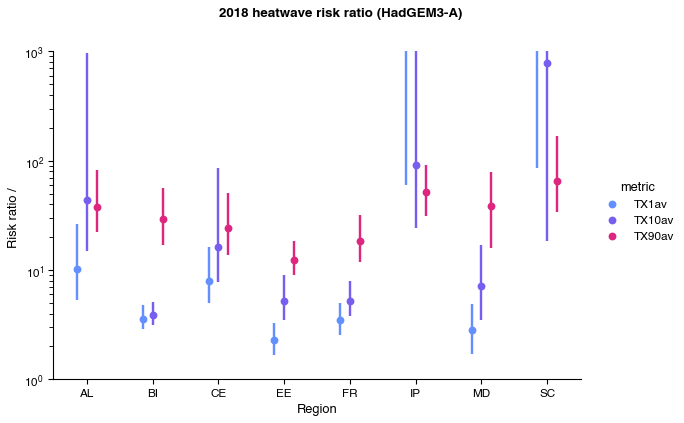

In [20]:
g=sn.catplot(data=(NAT_RG_boot.RP/ACT_RG_boot.RP).where(NAT_RG_boot.RP!=np.inf,1e6).to_dataframe().RP.reset_index(),y='RP',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','RP','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='Risk ratio / ',xlabel='Region',yscale='log',ylim=(1,1e3))
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('2018 heatwave risk ratio (HadGEM3-A)',fontweight='bold',y=1.05)
''

# Figure 1: plotting distributions

In [21]:
dist_palette = [get_palette.Petroff6().to_sn_palette()[i] for i in [0,2,4]]

## Plot E-Obs -> HadGEM3A CLIM

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))


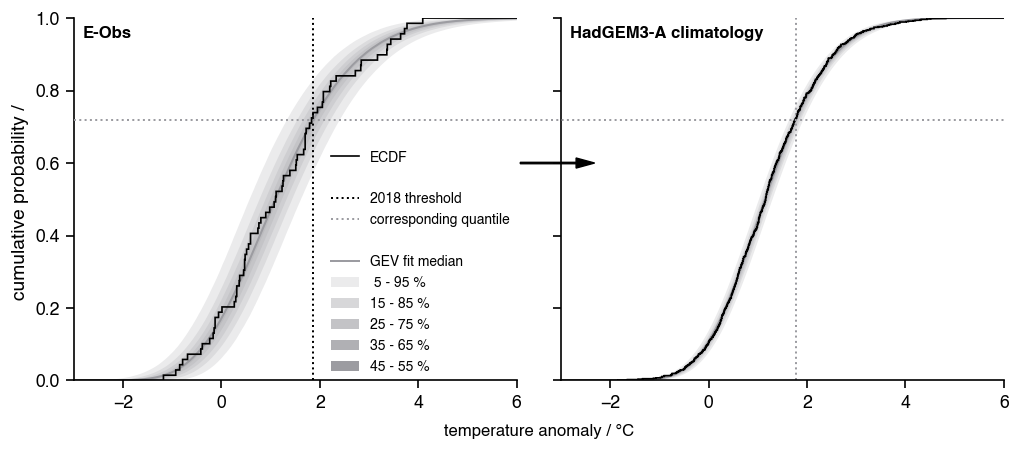

In [26]:
## figure options
axis_range = (-3,6)
xrange = np.arange(*axis_range,0.01)[:,None]

fig = plt.figure()
gs = fig.add_gridspec(1,2,wspace=0.1)

ax = [fig.add_subplot(gs[i]) for i in np.arange(2)]
ax_bg = fig.add_subplot(gs[:])
ax_bg.axis('off')

metric = 'TX1av'
    
## compute climatological average for anomalies
Obsav = EObs_RG.sel(region='BI',metric=metric,time=slice(1961,1990)).tg.mean(['time']).values[()]
CLIMav = CLIM_RG.sel(region='BI',metric=metric,time=slice(1961,1990)).tas.mean(['time','record']).values[()]

## plot E-Obs
Obsdata = EObs_RG_boot.sel(region='BI',metric=metric).tg_dt.values - Obsav
obsfit = LMoments.gev()
obsfit.fit(Obsdata)

cdf = obsfit.cdf(xrange)

for quant in np.arange(0.05,0.46,0.1):

    y = np.quantile(cdf,[quant,1-quant],axis=1)
    ax[0].fill_between(xrange[:,0],*y,alpha=0.2,color=dist_palette[2],lw=0)

ax[0].plot(xrange,np.median(cdf,axis=1),color=dist_palette[2])

## plot threshold
ax[0].axvline(EObs_RG.sel(region='BI',metric=metric,time=2018).tg-Obsav,color='k',ls=':')

## plot threshold in quantile space
ax_bg.axhline(1-1/EObs_RG_boot.RP.sel(metric=metric,region='BI').median(),color=dist_palette[2],ls=':')

## plot histogram
ax[0].hist(EObs_RG_boot.sel(region='BI',metric=metric,seed=0).tg_dt.values-Obsav,histtype='step',color='k',density=True,cumulative=True,bins=np.arange(-5,10,0.01),zorder=5,lw=1)

## plot HadGEM3-A climatology
CLIMdata = CLIM_RG_boot.sel(region='BI',metric=metric).tas_dt.values - CLIMav
CLIMfit = LMoments.gev()
CLIMfit.fit(CLIMdata)

cdf = CLIMfit.cdf(xrange)

for quant in np.arange(0.05,0.46,0.1):

    y = np.quantile(cdf,[quant,1-quant],axis=1)
    ax[1].fill_between(xrange[:,0],*y,alpha=0.2,color=dist_palette[2],lw=0)

ax[1].plot(xrange,np.median(cdf,axis=1),color=dist_palette[2])

## plot threshold
ax[1].axvline(CLIM_RG_boot.sel(metric=metric,region='BI').tas_threshold.median()-CLIMav,color=dist_palette[2],ls=':')

## plot histogram
ax[1].hist(CLIM_RG_boot.sel(region='BI',metric=metric,seed=0).tas_dt.values-CLIMav,histtype='step',color='k',density=True,cumulative=True,bins=np.arange(-5,10,0.01),zorder=5,lw=1)
    
## ax layout
[a.set_ylim(0,1) for a in ax+[ax_bg]]
[a.set_xlim(*axis_range) for a in ax]
ax[1].set_yticklabels([])
ax[0].set_ylabel('cumulative probability / ')
ax_bg.text(0.5,-0.12,'temperature anomaly / \N{DEGREE SIGN}C',ha='center',va='top',transform=ax_bg.transAxes)
ax[0].text(0.02,0.98,'E-Obs',transform=ax[0].transAxes,va='top',ha='left',fontweight='bold')
ax[1].text(0.02,0.98,'HadGEM3-A climatology',transform=ax[1].transAxes,va='top',ha='left',fontweight='bold')

## legend
ax[0].plot([],[],color='k',lw=1,label='ECDF')
ax[0].plot([],[],alpha=0,label=' ')
ax[0].plot([],[],color='k',ls=':',label='2018 threshold')
ax[0].plot([],[],color=dist_palette[2],ls=':',label='corresponding quantile')
ax[0].plot([],[],alpha=0,label=' ')
ax[0].plot([],[],color=dist_palette[2],label='GEV fit median')
for i,quant in enumerate(np.arange(0.05,0.46,0.1)):
    ax[0].fill_between([],[],[],alpha=0.2*(i+1),color=dist_palette[2],lw=0,label=f'{100*quant:2.0f} - {100*(1-quant):2.0f} %')
     
ax[0].legend(frameon=False,fontsize='small',loc=4,borderpad=0)

## arrow to indicate direction
arrow_width=0.004
ax_bg.arrow(x=0.48,y=0.6,dx=0.08,dy=0,length_includes_head=True,transform=ax_bg.transAxes,width=arrow_width,head_width=arrow_width*7,head_length=arrow_width*5,fc='k',ec='k')
    
## figure layout
sn.despine()
fig.patch.set_facecolor('xkcd:white')
fig.set_size_inches(10,4)
fig.dpi=120

## Plot ACT / NAT

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:231: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:231: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:231: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:231: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self

''

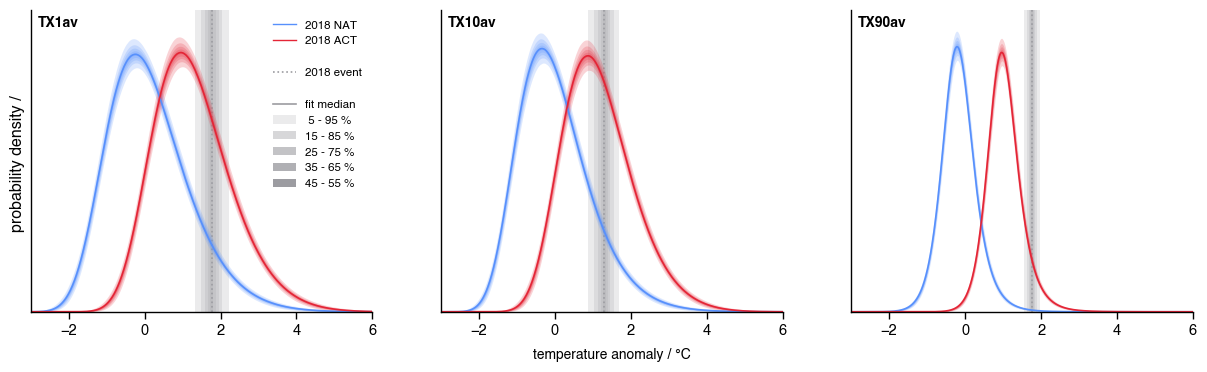

In [27]:
## figure options
axis_range = (-3,6)
xrange = np.arange(*axis_range,0.01)[:,None]

fig = plt.figure()
gs = fig.add_gridspec(1,3,wspace=0.2,hspace=0.05)

ax_hadgem = [fig.add_subplot(gs[i]) for i in np.arange(3)]
ax_bg = fig.add_subplot(gs[:])
ax_bg.axis('off')

for i,metric in enumerate(['TX1av','TX10av','TX90av']):
    
    ## compute climatological average for anomalies
    CLIMav = CLIM_RG.sel(region='BI',metric=metric,time=slice(1961,1990)).tas.mean(['time','record']).values[()]

    ## plot HadGEM ensembles
    for ii,ens in enumerate([NAT_RG_boot,ACT_RG_boot]):

        RGdata = ens.sel(region='BI',metric=metric).tas.values - CLIMav

        if metric == 'TX90av':
            fit = LMoments.glo()
        else:
            fit = LMoments.gev()
            
        fit.fit(RGdata)

        pdf = fit.pdf(xrange)
        
        pdf = pdf / pdf.max()

        for quant in np.arange(0.05,0.46,0.1):

            y = np.quantile(pdf,[quant,1-quant],axis=1)

            ax_hadgem[i].fill_between(xrange[:,0],*y,alpha=0.2,color=dist_palette[ii],lw=0)

        ax_hadgem[i].plot(xrange,np.median(pdf,axis=1),color=dist_palette[ii])

    ## plot climatological threshold
    threshdata = CLIM_RG_boot.tas_threshold.sel(region='BI',metric=metric).values - CLIMav
    for quant in np.arange(0.05,0.46,0.1):

        ax_hadgem[i].fill_betweenx([0,1],*np.quantile(threshdata,[quant,1-quant]),color=dist_palette[2],alpha=0.2,lw=0,zorder=-1)

    ax_hadgem[i].axvline(np.median(threshdata),color=dist_palette[2],ls=':',zorder=-1)   
    
    ax_hadgem[i].text(0.02,0.98,metric,transform=ax_hadgem[i].transAxes,va='top',ha='left',fontweight='bold')

## axes layout
[a.set_xlim(*axis_range) for a in ax_hadgem]
[a.set_ylim(0,1) for a in ax_hadgem]
[a.set_yticks([]) for a in ax_hadgem]
ax_hadgem[0].set_ylabel('probability density / ')
ax_bg.text(0.5,-0.12,'temperature anomaly / \N{DEGREE SIGN}C',ha='center',va='top',transform=ax_bg.transAxes)

## legend
ax_hadgem[0].plot([],[],color=dist_palette[0],lw=1,label='2018 NAT')
ax_hadgem[0].plot([],[],color=dist_palette[1],lw=1,label='2018 ACT')
ax_hadgem[0].plot([],[],alpha=0,label=' ')
ax_hadgem[0].plot([],[],color=dist_palette[2],ls=':',label='2018 event')
ax_hadgem[0].plot([],[],alpha=0,label=' ')
ax_hadgem[0].plot([],[],color=dist_palette[2],label='fit median')
for i,quant in enumerate(np.arange(0.05,0.46,0.1)):
    ax_hadgem[0].fill_between([],[],[],alpha=0.2*(i+1),color=dist_palette[2],lw=0,label=f'{100*quant:2.0f} - {100*(1-quant):2.0f} %')
     
ax_hadgem[0].legend(frameon=False,fontsize='small',loc=1)

## figure layout
sn.despine()
fig.patch.set_facecolor('xkcd:white')
fig.set_size_inches(15,4)
fig.dpi=100

''